# Custom image detection with fast.ai

This notebook started as a copy of the lesson 1 notebook in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. I **highly** recommend this free online course. I have just started, yet within the first couple of lessons, I was able to get real results of my own.

I've retained much of the descriptive text and code from that class -- so this work is mainly that of Howard's, and not mine.

Running the code in this notebook -- and the class -- will require some setup, [which is described here](https://course.fast.ai/index.html).

Also you'll need the images I used, which are in this repo as `choppers.zip`.

For more of my process here, see [this blog post](https://qz.ai/spotting-circling-helicopters/).

-- John Keefe

In [1]:
## ALL COLAB NOTEBOOK USERS SHOULD RUN THIS CELL

# This script loads the fast.ai library
!curl -s https://course.fast.ai/setup/colab | bash

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

## The plan

We're going to train a model to recognize helicopter flight maps as either "circling" or "not circling" using a relatively small number of training images (just shy of 200 total).

- We'll start with a moodel pre-trained on 14 million image.
- Next we'll use "transfer learning" with fast.ai to further train that model with our helicopter maps

## The data

In [ ]:
# This cell gets the images off our servers and unzips them.

## TK

Probably the trickiest part of machine learning image problems involve pairing the images with their proper labels. There are many ways to do this. Sometimes the labels are in the file names. Sometimes they're in a list. Ours are in two separate folders, or directories: 

- Folder `1` contains the circling images
- Folder `0` contains non-circling images

I made these folders by sorting through about 200 maps of helicopter flight paths.

In [ ]:
path = Path('./choppers')

In [6]:
path.ls()

[PosixPath('/home/ubuntu/data/choppers/export.pkl'),
 PosixPath('/home/ubuntu/data/choppers/1'),
 PosixPath('/home/ubuntu/data/choppers/0'),
 PosixPath('/home/ubuntu/data/choppers/models')]

In [7]:
tfms = None  # note: Transformations seem best suited for real-world pics; so I turned this off.

np.random.seed(2) # ensures the same validation set every time, so can compare changes 

data = (ImageList.from_folder(path) # Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()        # How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder()        # How to label? -> get from the folder name
        .transform(tfms, size=600)  # Data augmentation? -> use tfms with a size of 600, because they all are
        .databunch(bs=16))          # Size of simultaneous batches -> 16 (higher is faster & uses more memory)

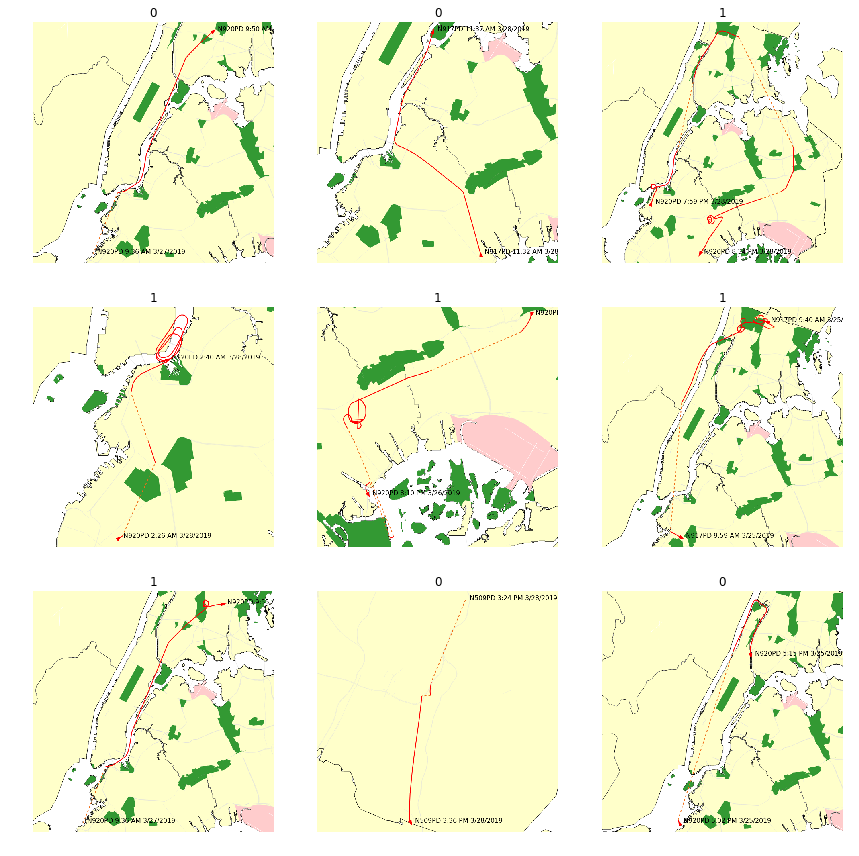

In [8]:
data.show_batch(rows=3)

In [9]:
print(data.classes)

['0', '1']


(2, 2)

## Training our model

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Most people don't! For a deeper dive, check out the fast.ai courses. 

But for now, you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories: `0` and `1`

### Transfer learning with resnet34

Training a computer-vision mode from scratch to solve our problem would take thousands of images. Maybe more. Instead we take advantage of an existing model that was trained to detect objects -- from planes, to cars, to dogs, to birds -- by processing millions of images. This model is called "resnet34."

With fast.ai we can infuse this model with our images (and their labels). This takes advantage of all of resnet34's "knowledge" of image-detection and tacks on our particular problem. This technique is called "transfer learning." 

First we load our `data` and `model.resnet34` together into a training model known as a "learner."

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

We will train for 4 epochs (4 cycles through all our data).

In [31]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.900236,0.656154,0.361111,00:09
1,0.620992,0.605561,0.416667,00:09
2,0.519490,0.494210,0.250000,00:09
3,0.425946,0.286636,0.111111,00:09


### How are we doing? 

So far, we have an error rate of 11% ... which isn't bad. It makes a mistake about one in ten images.

We can take a look to see where the model was most confused, and whether what the model predicted was reasonable or not. 

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

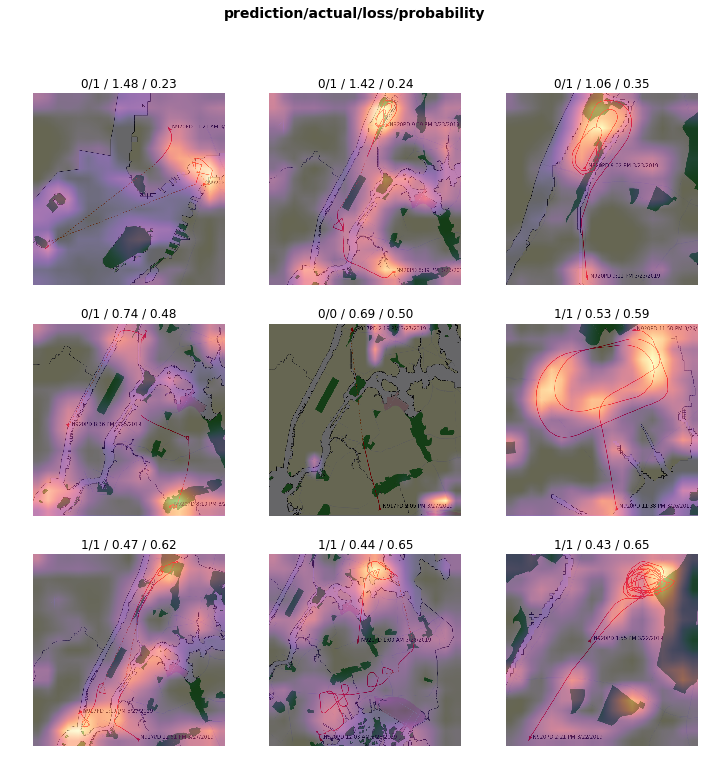

In [33]:
interp.plot_top_losses(9)

The "hot" areas of the images are the parts the model is using to make its decision.

In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

In [35]:
interp.most_confused(min_val=2)

[('1', '0', 4)]

In [ ]:
# Let's save our model
learn.save('helicopters-1')

### Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.345058,0.497258,0.194444,00:12
1,0.347629,0.965326,0.277778,00:12


That actually didn't help. So loading back the original model.

In [39]:
learn.load('helicopters-1');

Here we're looking at whether we can do better by fine-tuning the learning rate. Jeremy says mainly you need to tinker with the learning rate and/or the epochs to get the best result. I'm still learning about the learning rate. :-)

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


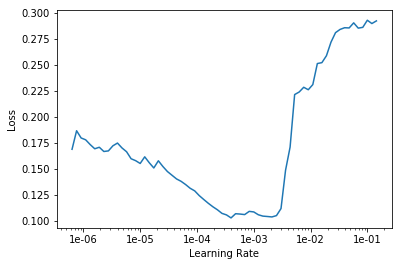

In [41]:
learn.recorder.plot()

In [42]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.164227,0.200703,0.055556,00:12
1,0.136653,0.207121,0.055556,00:12


In [43]:
# 94% accuracy! Save that! 

learn.save('helicopters-2')

In [46]:
learn.export()  #this creates a pickle file with all the info we need for the next steps

## Doing this in production

This actually comes from the second lesson, in which Jeremy talks about putting these models into production.

In [47]:
data.classes

['0', '1']

Production computers can use the model on a CPU -- without the need for a GPU. Also it's better that way. So here I tell the computer to use the CPU instead of the GPU

In [48]:
defaults.device = torch.device('cpu')  # for the gpu it would be 'cuda'

Now I grab a single, brand new image.

In [53]:
img = open_image('/home/ubuntu/data/newimages/N920PD2019-04-02_00_20_21.png')

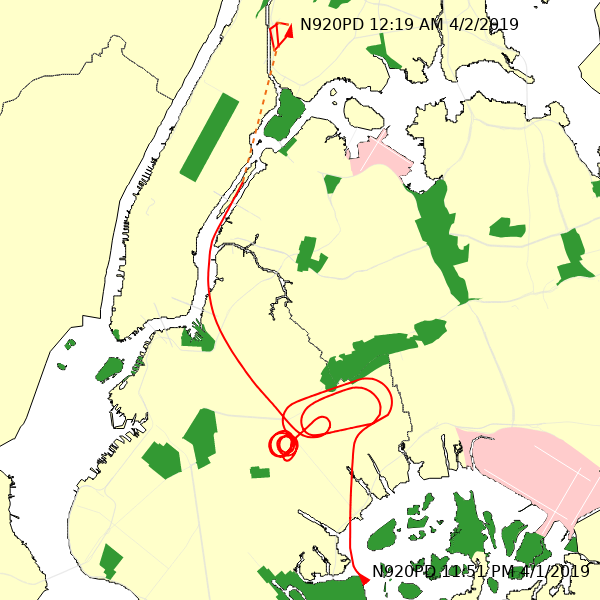

In [54]:
img

In [55]:
learn = load_learner(path)  # this gets the exported pickle file, which is stored in the image data path

In [56]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category 1

"Category 1" is circling!